# ```ASSIGNMENT 1A - REGRESSION WITHOUT REGULARIZATION```

### ```TEAM MEMBERS: ```
        1. Pavas Garg - 2021A7PS2587H
        2. Tushar Raghani - 2021A7PS1404H
        3. Rohan Pothireddy - 2021A7PS0365H 

## ```Importing the Libraries```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

## `⏳ Loading the Dataset`

In [2]:
dataset = pd.read_csv("Data - A1.csv")

In [3]:
dataset.head()

X         Y
0  0.987988  5.098368
1  0.719720  2.516654
2 -0.403403  0.337961
3  0.107107  0.737320
4  0.345345 -0.780955

In [4]:
print("Number of records in the given dataset are: ",len(dataset))
print("Number of features in the given dataset are: ",len(dataset.columns)-1)

Number of records in the given dataset are:  1000
Number of features in the given dataset are:  1


# ```TASK 1: DATA PREPROCESSING```

## ```🔬Preprocess and perform exploratory data analysis of the dataset obtained```

### Normalization Method
- Normalization is performed to transform the data to have a mean of 0 and standard deviation of 1
- Normalization is also known as Z-Score Normalization

\begin{equation}
z = \frac{(x-\mu)}{\sigma}
\end{equation}

In [5]:
# function for finding mean of a feature in a given dataset
def find_mean(dataset,feature):
    n = len(dataset[feature])
    sum = 0
    for val in dataset[feature]:
        sum += val
    return sum/n

In [6]:
# function for finding standard deviation of a feature in a given dataset
def find_standard_deviation(dataset,feature):
    variance, squared_sum = 0,0
    n = len(dataset[feature])
    mean = find_mean(dataset,feature)
    for val in dataset[feature]:
        squared_sum += (val-mean)**2
    variance = squared_sum/n
    return math.sqrt(variance)

In [7]:
# function for scaling a feature in given dataset
def normalize_feature(dataset,feature):
    mean = find_mean(dataset,feature)
    standard_deviation = find_standard_deviation(dataset,feature)
    normalized_feature = []
    for val in dataset[feature]:
        normalized_feature.append((val-mean)/standard_deviation)
    return normalized_feature

In [8]:
# function for scaling (standardizing) the whole dataset
def normalize_dataset(dataset):
    df = dataset.drop(columns = 'Y')
    normalized_df = pd.DataFrame()
    for feature in df.columns:
        normalized_result = normalize_feature(df,feature)
        normalized_df[feature] = normalized_result
        
# When copying columns from one DataFrame to another, you might get NaN values in the resulting DataFrame.
# The issue is caused because the indexes of the DataFrames are different.
# This causes the indexes for each column to be different.
# When pandas tries to align the indexes when assigning columns to the second DataFrame, it fails and inserts NaN values.
# One way to resolve the issue is to homogenize the index values.
# for eg [a,b,c,d] for df1 and indices for df2 are [1,2,3,4]
# that's why use df1.index = df2.index

    normalized_df.index = dataset.index 
    normalized_df['Y'] = dataset['Y']
    return normalized_df

In [9]:
# normalizing the complete dataset
dataset = normalize_dataset(dataset)
dataset.head()

X         Y
0  1.709535  5.098368
1  1.245345  2.516654
2 -0.698017  0.337961
3  0.185330  0.737320
4  0.597558 -0.780955

In [10]:
# checking mean and variance of each feature after standardizing the dataset
df = dataset.drop(columns = 'Y')
for feature in df:
    print("Mean of",feature,"is",round(find_mean(dataset,feature)))
    print("Standard Deviation of",feature,"is",round(find_standard_deviation(dataset,feature)))

Mean of X is 0
Standard Deviation of X is 1


## `Plot showing distribution of feature after normalization`

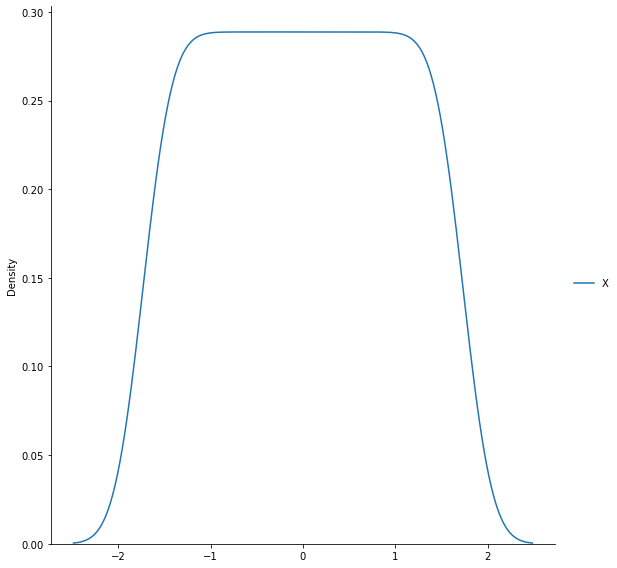

In [11]:
# all features following a normal distribution with mean 0 and standard deviation of 1
sns.displot(dataset.drop(columns='Y'), kind='kde',aspect=1,height=8)
plt.show()

## `Train-Test Split`

In [12]:
def split_train_test(data,test_ratio):
    # np.random.seed() is very important as whenever we call the function it will randomly divide the indices
    # it might happen after many calls our model sees all the data and it leads to overfitting so to prevent it
    # seed function will randomly divide data only once and once the function is called it will not give other
    # permuatation of indices whenever called again,hence no overfitting
    np.random.seed(45)
    # it will give random permutation of indices from 0 to len(data)-1
    # now shuffled array will contain random number for eg [0,4,1,99,12,3...]
    shuffled = np.random.permutation(len(data))  
    test_set_size = int(len(data)*test_ratio)
    # it will give array of indices from index 0 to test_set_size-1
    test_indices = shuffled[:test_set_size]
    # it will give array of indices from index test_set_size till last
    train_indices = shuffled[test_set_size:]
    # it will return rows from data df corresponding to indices given in train and test indices array
    # so it is returning the train and test data respectively
    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
constants = []
for i in range(len(dataset)):
    constants.append(1)
dataset["X0"] = constants
dataset.iloc[:,[2,0,1]]

X0         X         Y
0     1  1.709535  5.098368
1     1  1.245345  2.516654
2     1 -0.698017  0.337961
3     1  0.185330  0.737320
4     1  0.597558 -0.780955
..   ..       ...       ...
995   1  1.162207  3.079356
996   1 -1.065212  0.027487
997   1  0.448601  1.068320
998   1  0.206114  0.245188
999   1  0.639127  0.545114

[1000 rows x 3 columns]

In [14]:
train_set, test_set = split_train_test(dataset,0.2)

In [15]:
train_set.head()

X         Y  X0
791 -0.940504 -0.239653   1
143 -0.867758 -0.970942   1
880  0.368927  0.928281   1
339  0.874686  1.964894   1
992 -0.486707  1.531339   1

In [16]:
len(train_set)

800

In [17]:
test_set.head()

X         Y  X0
726 -1.425479 -2.307222   1
243 -0.469386  0.904469   1
342 -1.321555 -0.168041   1
976 -1.127566 -1.141138   1
919 -0.618342  0.004463   1

In [18]:
len(test_set)

200

# ```TASK 2: POLYNOMIAL REGRESSION```

In [19]:
# function for generating polynomial for a dataset with a given degree
def generate_polynomial(degree,feature,dataset):
    generated_dataset = pd.DataFrame()
    generated_dataset["X0"] = dataset["X0"]
    generated_dataset["X"] = dataset["X"]
    for deg in range(2,degree+1):
        vector = dataset[feature].to_numpy()
        vector_degree = [x**deg for x in vector]
        generated_dataset[f'X^{deg}'] = vector_degree
    generated_dataset["Y"] = dataset["Y"]
    return generated_dataset

In [20]:
dataset_temp = generate_polynomial(9,"X",dataset)
print(dataset_temp.head())

   X0         X       X^2       X^3       X^4        X^5        X^6  \
0   1  1.709535  2.922510  4.996133  8.541064  14.601248  24.961345   
1   1  1.245345  1.550885  1.931387  2.405243   2.995358   3.730254   
2   1 -0.698017  0.487227 -0.340093  0.237391  -0.165703   0.115663   
3   1  0.185330  0.034347  0.006366  0.001180   0.000219   0.000041   
4   1  0.597558  0.357075  0.213373  0.127503   0.076190   0.045528   

         X^7        X^8           X^9         Y  
0  42.672293  72.949778  1.247102e+02  5.098368  
1   4.645454   5.785193  7.204563e+00  2.516654  
2  -0.080735   0.056354 -3.933626e-02  0.337961  
3   0.000008   0.000001  2.579298e-07  0.737320  
4   0.027206   0.016257  9.714478e-03 -0.780955  


## `Batch Gradient Descent Algorithm`

### `Gradient Descent Algorithm`

- We will use this equation to update our linear regression model parameters

$$
\begin{equation}
\theta_{j} = \theta_{j} - {\alpha}\frac{\partial J(\theta)}{\partial \theta_{j}}  ,\quad\text {$0 \leq j \leq d$} 
\end{equation}
$$

$$
\begin{equation}
\frac{\partial J(\theta)}{\partial \theta_{j}} = \sum_{i=1}^n(h_{\theta}(x) - y^{(i)})*x_{j}^{(i)}, \quad h_{\theta}(x) = \theta_{0} + \theta_{1}x_{1}  + \theta_{2}x_{2}  +  ... +  \theta_{d}x_{d}
\end{equation}
$$

- Repeat until convergence
$$
\begin{equation}
\theta_{j} = \theta_{j} - {\alpha}\sum_{i=1}^n(h_{\theta}(x) - y^{(i)})*x_{j}^{(i)} ,\quad\text {$0 \leq j \leq d$}
\end{equation}
$$

- Such that it minimizes the cost function given by equation

$$
\begin{equation}
J(\theta) = {\frac{1}{2}}\sum_{i=1}^n{(h_{\theta}(x)^{(i)} - y^{(i)})^2}
\end{equation}
$$

In [21]:
def give_train_data(dataset,feature,degree):
    df = generate_polynomial(degree,feature,dataset)
    train_set, test_set = split_train_test(df,0.2)
    x_train = train_set.drop(columns="Y")
    x_train = x_train.to_numpy()
    y_train = train_set["Y"]
    y_train = y_train.to_numpy()
    
    x_test = test_set.drop(columns="Y")
    x_ttest = x_test.to_numpy()
    y_test = test_set["Y"]
    y_test = y_test.to_numpy()
    return x_train, y_train, x_test, y_test

In [22]:
def give_weight_vector(degree):
    weight_vector = np.random.randn(degree+1)
    return weight_vector

In [23]:
# function to find cost value, using the formula for J(theta)
def find_cost(y_actual,y_predicted):
    cost = 0
    for i in range(len(y_actual)):
        cost += (y_predicted[i] - y_actual[i])**2
    return (1/2)*cost

In [24]:
def print_cost_function(iteration_x_axis_batch,cost_y_axis_batch):
    plt.plot(iteration_x_axis_batch,cost_y_axis_batch)
    plt.xlabel("Iterations")
    plt.ylabel("Cost Value")
    plt.show()

In [25]:
max_iterations = 500

In [26]:
# function for finding the predicted value
def find_predicted_value(weight_vector,x_train):
    return np.dot(x_train,weight_vector)

In [27]:
# function for finding mse and sse
def find_sse_mse(y_actual,y_predicted):
    sse = 0
    for index in range(len(y_actual)):
        sse += (y_actual[index]-y_predicted[index])**2
    mse = sse**0.5
    return sse, mse

In [28]:
# function for finding mse (to plot graphs)
def find_mse(y_actual,y_predicted):
    sse = 0
    for index in range(len(y_actual)):
        sse += (y_actual[index]-y_predicted[index])**2
    mse = sse**0.5
    return mse

In [29]:
def batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch):
    prev_cost = 0
    
    # get x_train and y_train vectors
    x_train_batch, y_train_batch, x_test_batch, y_test_batch = give_train_data(dataset,feature,degree)
    
    # get the weight vector with degree+1 weights
    weight_vector = give_weight_vector(degree)
    
    for iteration in range(max_iterations):
        # will give the predicted value, after each iteration using updated weights
        
        y_predicted = np.dot(x_train_batch,weight_vector) 
        current_cost = find_cost(y_train_batch,y_predicted)
        mse = find_mse(y_train_batch,y_predicted)   
        # this loop will update all the parameters one by one
        for theta_j in range(len(weight_vector)):
            
            # defining the xj vector for the column corresponding the weight theta_j
            xj_vector = x_train_batch[:,theta_j]
            
            # defining the vector representing the difference between predicted and actual values
            difference_actual_predicted_vector = (y_predicted-y_train_batch).reshape(len(x_train_batch),-1)
            
            gradient =  np.dot(xj_vector,difference_actual_predicted_vector)
            weight_vector[theta_j] = weight_vector[theta_j] - learning_rate *gradient

        

        
        # adding cost to cost array after each iteration
        iteration_x_axis_batch.append(iteration)
        cost_y_axis_batch.append(current_cost)
        mse_y_batch.append(mse)
    
    return weight_vector

In [30]:
# scatter plot for predicted and actual values
def plot_graph_predicted_values(y_actual,y_predicted,length):
    plt.scatter([index for index in range(0,length)],y_predicted)
    plt.scatter([index for index in range(0,length)],y_actual,color='orange')
    plt.legend(['Predicted Values','Actual Values'])
    plt.show()

In [31]:
def plot_poly(x_train,y_actual,weight_vector):
    sorted_indices = np.argsort(x_train, axis=0)
    a = len(weight_vector)
    x_train_sorted = np.take_along_axis(x_train, sorted_indices, axis=0)
    y_predicted = find_predicted_value(weight_vector,x_train_sorted)
    df = pd.DataFrame(x_train_sorted, columns = ["fX{i}" for i in range(a)])
    X = df.iloc[:,1]
    plt.title("Y vs X")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.scatter(X,y_actual,label ="Actual Values")
    plt.plot(X,y_predicted,marker ='x' ,color = 'orange',label = "Predicted Curve")
    plt.legend()
    plt.show()

In [32]:
def print_score(y_train_actual,x_train,y_test_actual,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch):
    print("Cost Function:\n================================================\n")
    print_cost_function(iteration_x_axis_batch,cost_y_axis_batch)
    
    sse, mse = find_sse_mse(y_train_actual,find_predicted_value(weight_vector,x_train))
    print("Train Result:\n================================================\n")
    print("SSE for this regression model is: ",sse)
    print("MSE for this regression model is: ",mse)
    plot_graph_predicted_values(y_train_actual,find_predicted_value(weight_vector,x_train),len(x_train))
    plot_poly(x_train,y_train_actual,weight_vector)

    print("Test Result:\n================================================\n")
    sse, mse = find_sse_mse(y_test_actual,find_predicted_value(weight_vector,x_test))
    print("SSE for this regression model is: ",sse)
    print("MSE for this regression model is: ",mse)
    plot_graph_predicted_values(y_test_actual,find_predicted_value(weight_vector,x_test),len(x_test))
    plot_poly(x_test.to_numpy(),y_test_actual,weight_vector)

## ```Test Run for Polynomial with degree 1```

Cost Function:



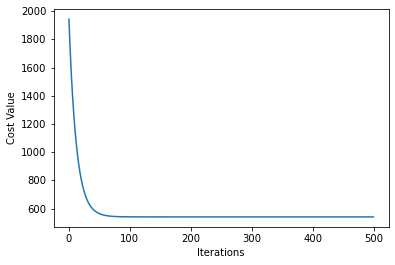

Train Result:

SSE for this regression model is:  1081.04800332239
MSE for this regression model is:  32.879294446845876


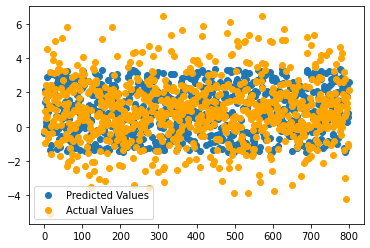

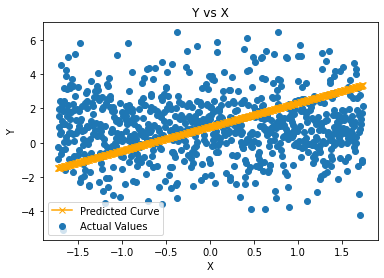

Test Result:

SSE for this regression model is:  272.71718566458657
MSE for this regression model is:  16.51415107308234


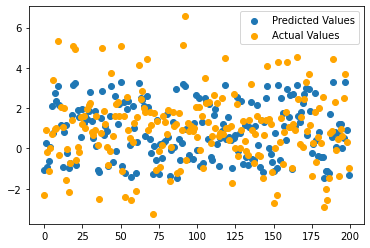

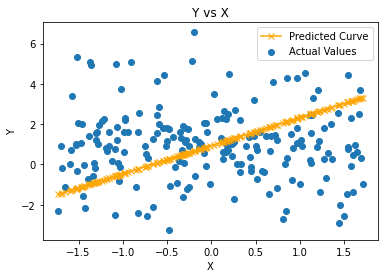

In [33]:
# for alpha = 0.00005
learning_rate = 0.00005
degree = 1
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []
weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

Cost Function:



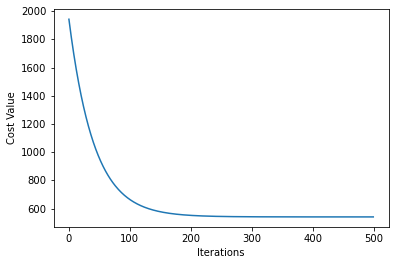

Train Result:

SSE for this regression model is:  1081.0627782321756
MSE for this regression model is:  32.879519130184605


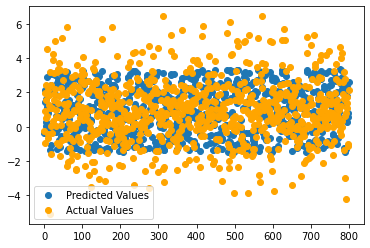

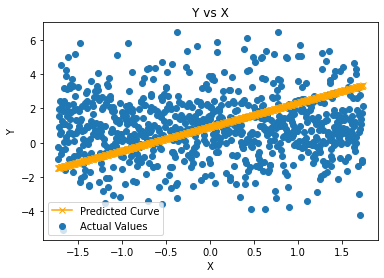

Test Result:

SSE for this regression model is:  272.89579361204983
MSE for this regression model is:  16.519557912124945


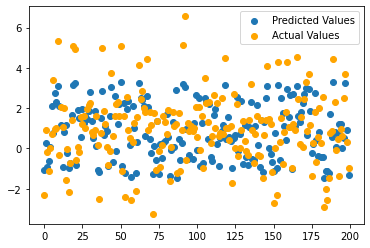

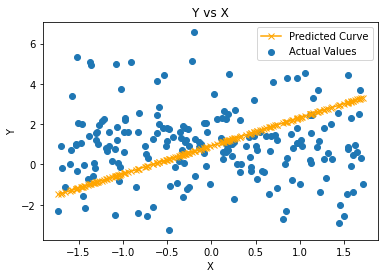

In [34]:
# for alpha = 0.0001
learning_rate = 0.000015
degree = 1
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch =[]
weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

Cost Function:



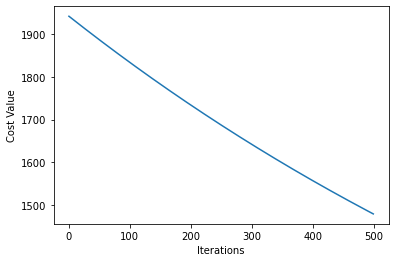

Train Result:

SSE for this regression model is:  2955.10883090548
MSE for this regression model is:  54.36091271221888


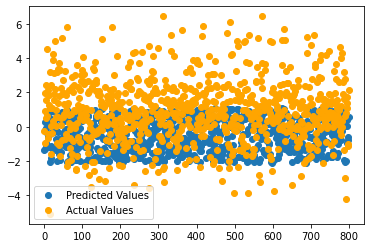

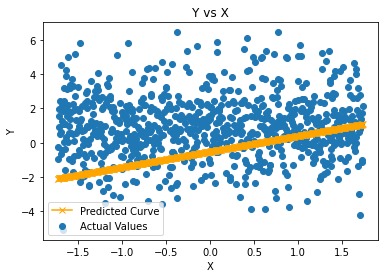

Test Result:

SSE for this regression model is:  782.7209674522234
MSE for this regression model is:  27.97715081012045


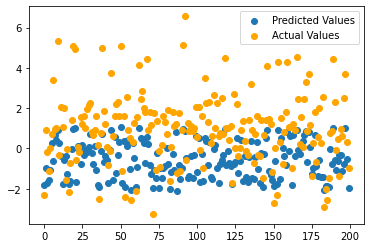

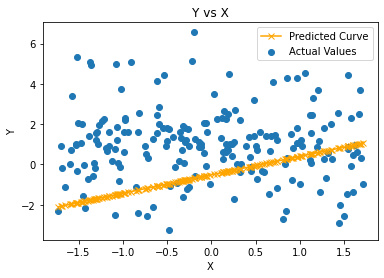

In [35]:
# for alpha = 0.0000005
learning_rate = 0.0000005
degree = 1
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

# ```Test Run for Polynomial with degree 2```

Cost Function:



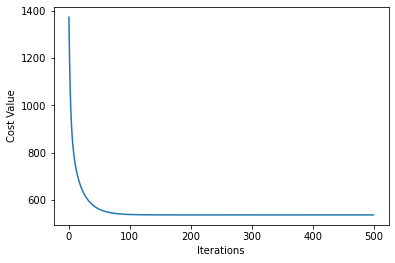

Train Result:

SSE for this regression model is:  1071.7762172088362
MSE for this regression model is:  32.73799348171534


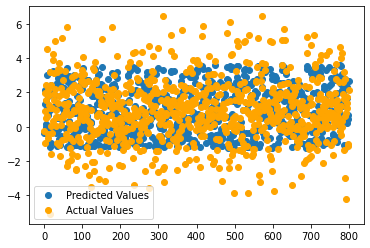

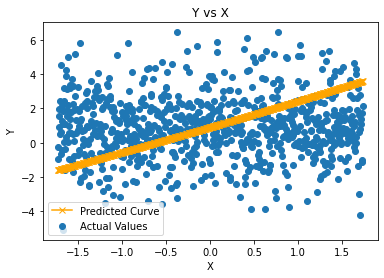

Test Result:

SSE for this regression model is:  272.8746130532337
MSE for this regression model is:  16.51891682445413


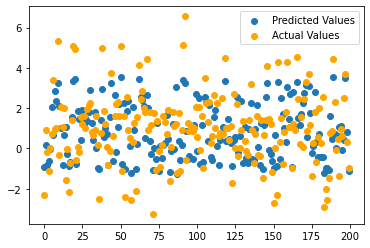

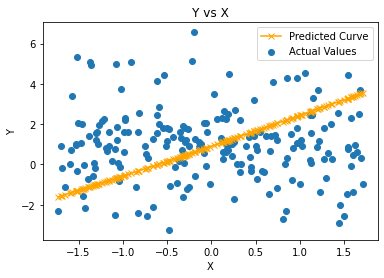

In [36]:
# for alpha = 0.0001
learning_rate = 0.0001
degree = 2
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

Cost Function:



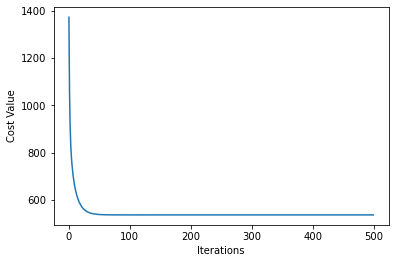

Train Result:

SSE for this regression model is:  1071.7762172054372
MSE for this regression model is:  32.73799348166343


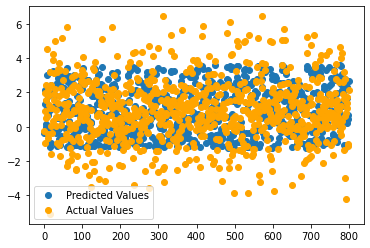

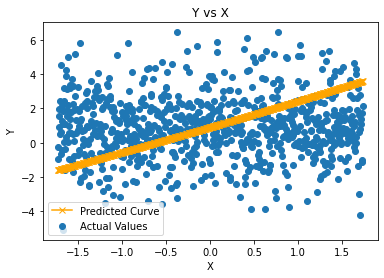

Test Result:

SSE for this regression model is:  272.8745225032728
MSE for this regression model is:  16.518914083657943


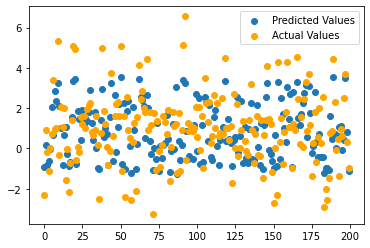

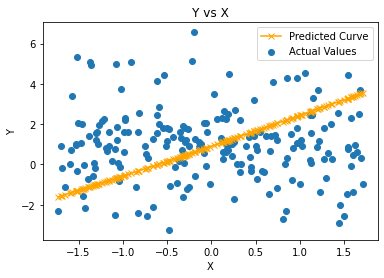

In [37]:
# for alpha = 0.0001
learning_rate = 0.0002
degree = 2
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

Cost Function:



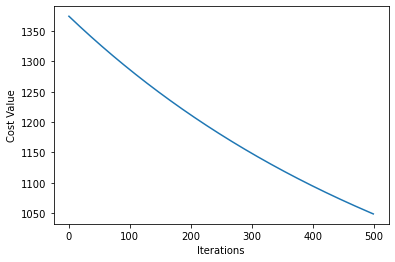

Train Result:

SSE for this regression model is:  2096.4889196468525
MSE for this regression model is:  45.78743189617488


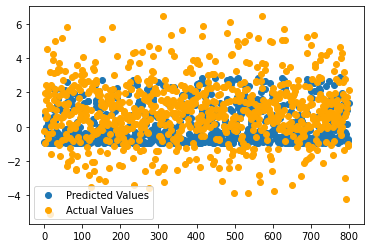

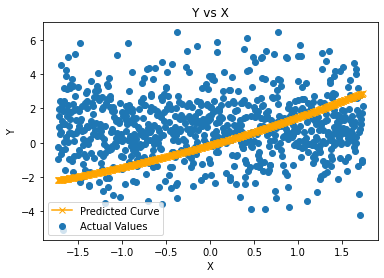

Test Result:

SSE for this regression model is:  574.6687756782768
MSE for this regression model is:  23.97225011713078


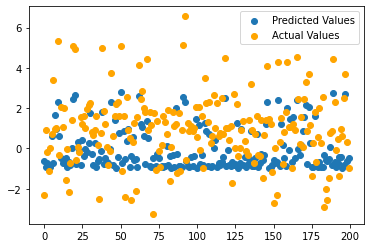

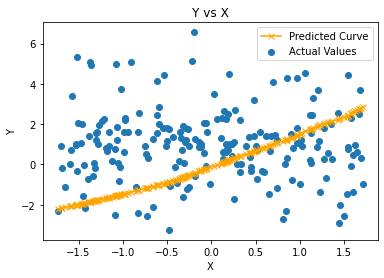

In [38]:
# for alpha = 0.0000005
learning_rate = 0.0000005
degree = 2
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

### ```Test Run for Polynomial with degree 3```

Cost Function:



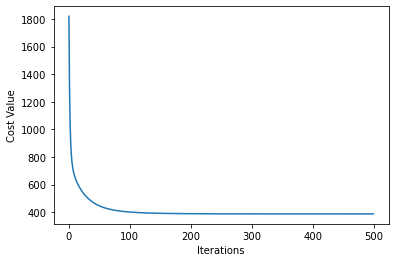

Train Result:

SSE for this regression model is:  775.9028139727806
MSE for this regression model is:  27.85503211221952


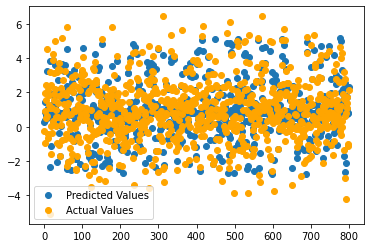

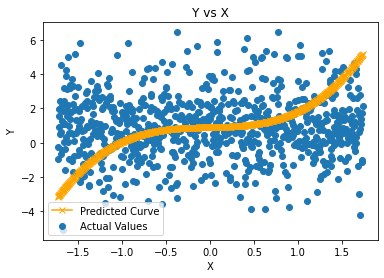

Test Result:

SSE for this regression model is:  189.88952313306535
MSE for this regression model is:  13.780040752228034


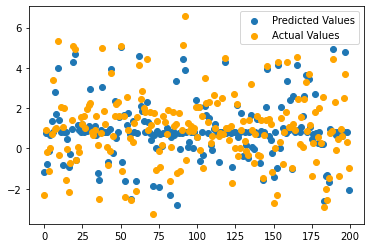

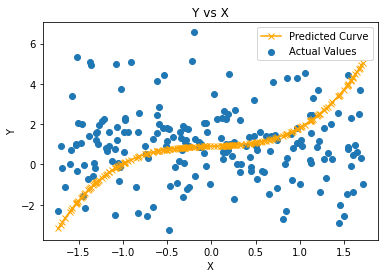

In [39]:
# for alpha = 0.0001
learning_rate = 0.00009
degree = 3
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

Cost Function:



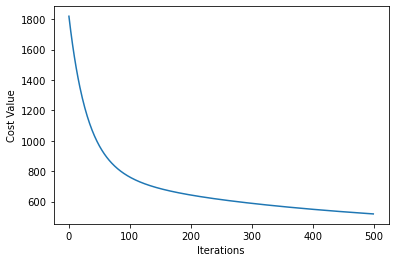

Train Result:

SSE for this regression model is:  1036.1249691062128
MSE for this regression model is:  32.188895120929715


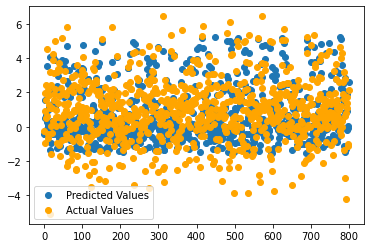

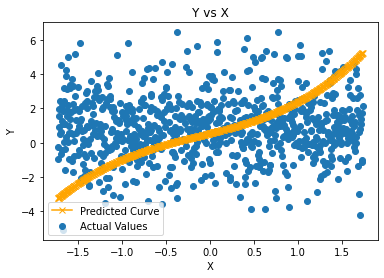

Test Result:

SSE for this regression model is:  286.65451030609785
MSE for this regression model is:  16.930874469621994


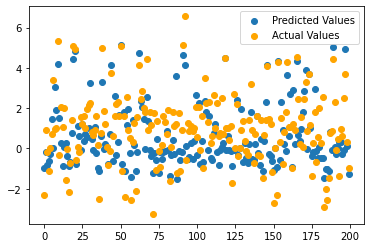

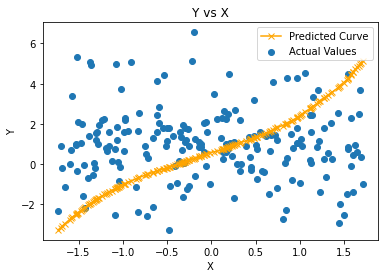

In [40]:
# for alpha = 0.0001
learning_rate = 0.000005
degree = 3
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

Cost Function:



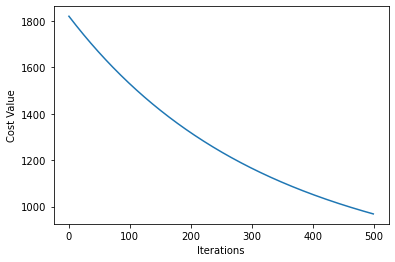

Train Result:

SSE for this regression model is:  1935.7236711593546
MSE for this regression model is:  43.996859787482045


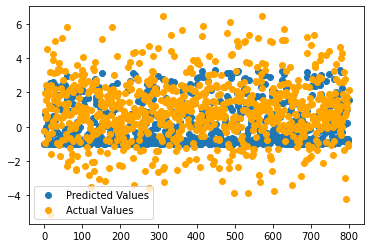

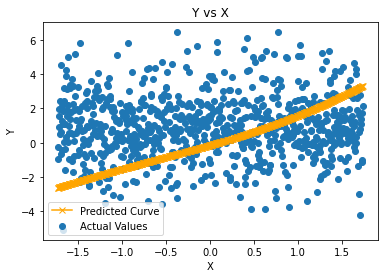

Test Result:

SSE for this regression model is:  541.7303757249754
MSE for this regression model is:  23.275102056166702


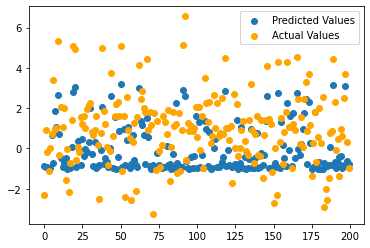

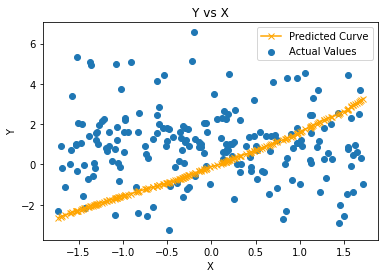

In [41]:
# for alpha = 0.0000005
learning_rate = 0.0000005
degree = 3
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []
weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

## ```Test Run for Polynomial with degree 4```

Cost Function:



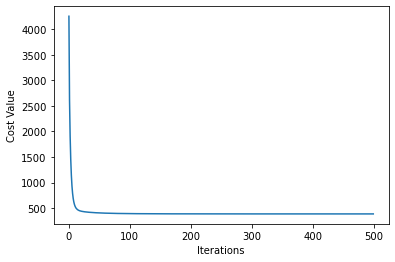

Train Result:

SSE for this regression model is:  775.9062636419245
MSE for this regression model is:  27.85509403398101


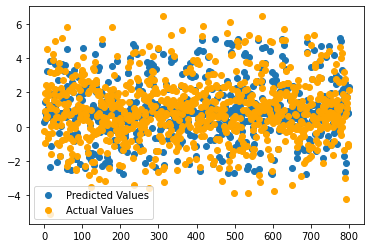

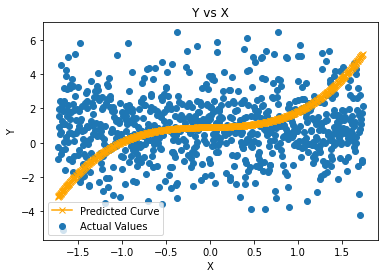

Test Result:

SSE for this regression model is:  189.99945688951647
MSE for this regression model is:  13.784029051388293


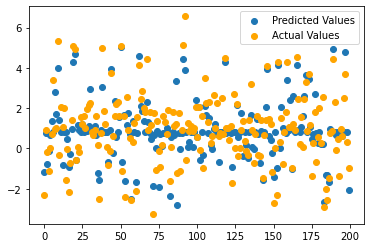

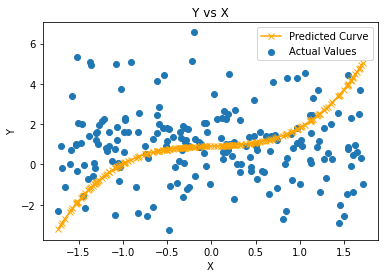

In [42]:
# for alpha = 0.0001
learning_rate = 0.0002
degree = 4
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

Cost Function:



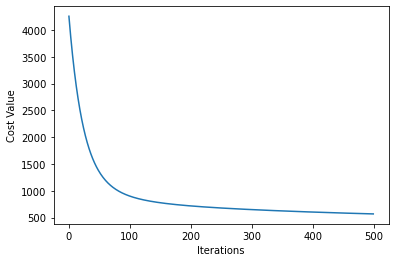

Train Result:

SSE for this regression model is:  1138.0978039810648
MSE for this regression model is:  33.73570517983973


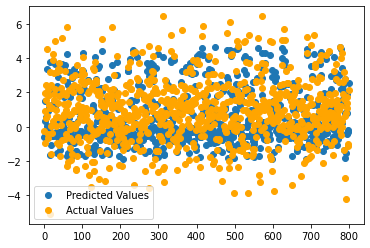

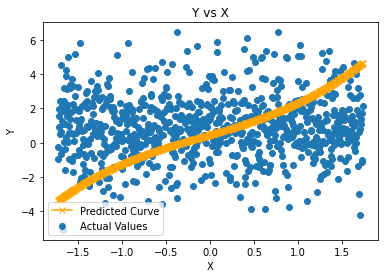

Test Result:

SSE for this regression model is:  328.83506335627607
MSE for this regression model is:  18.133809951476717


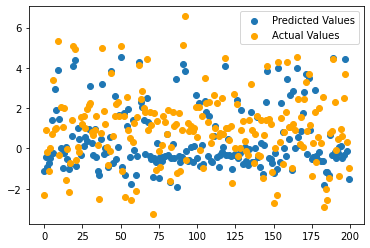

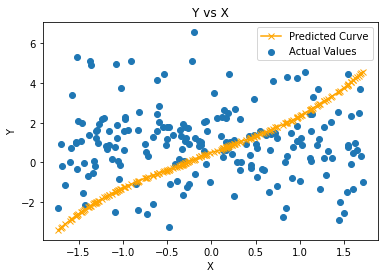

In [43]:
# for alpha = 0.0001
learning_rate = 0.0000025
degree = 4
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

Cost Function:



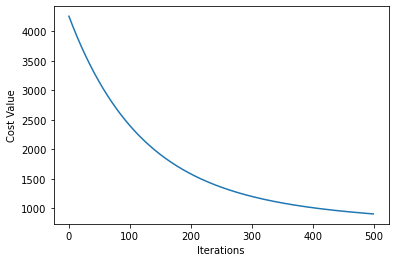

Train Result:

SSE for this regression model is:  1804.8857303524626
MSE for this regression model is:  42.48394673700247


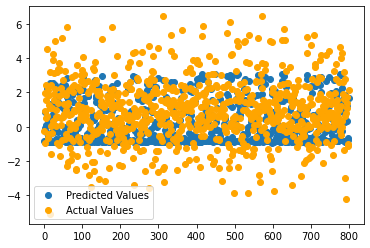

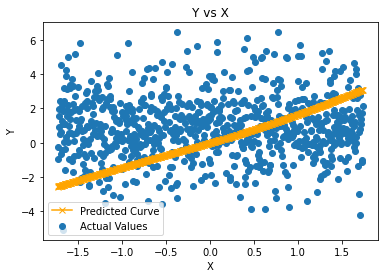

Test Result:

SSE for this regression model is:  508.3594981900238
MSE for this regression model is:  22.54682900520656


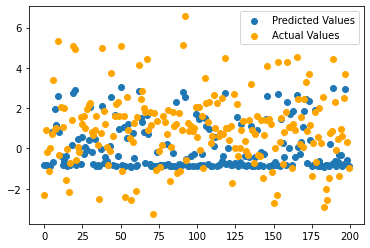

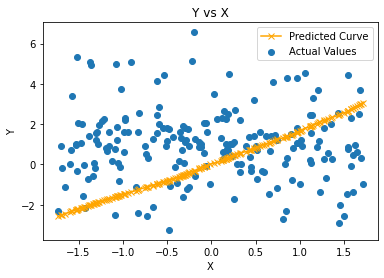

In [44]:
# for alpha = 0.0000005
learning_rate = 0.0000005
degree = 4
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

## ```Test Run for Polynomial with degree 5```

Cost Function:



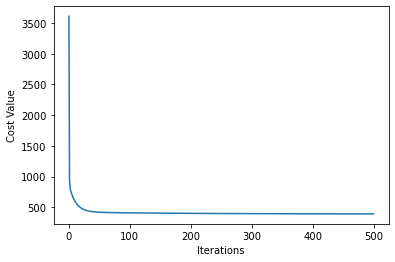

Train Result:

SSE for this regression model is:  783.5512167394083
MSE for this regression model is:  27.991984866018495


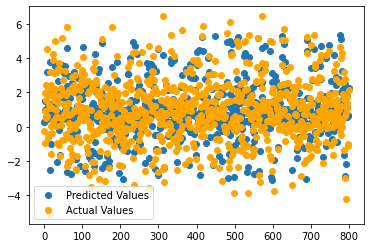

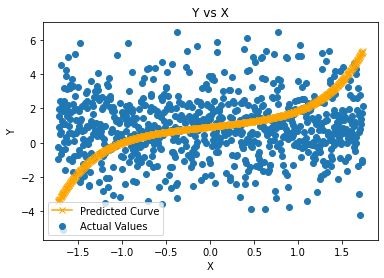

Test Result:

SSE for this regression model is:  198.1536632169333
MSE for this regression model is:  14.076706405155052


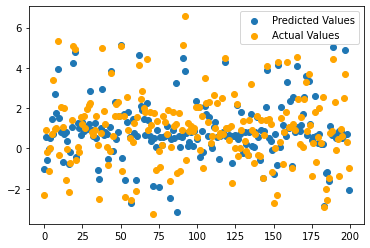

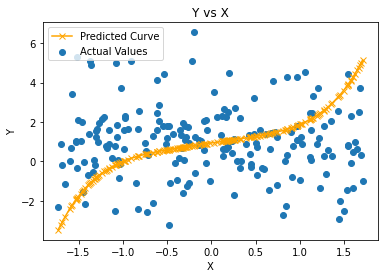

In [45]:
# for alpha = 0.0001
learning_rate = 0.00009
degree = 5
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

Cost Function:



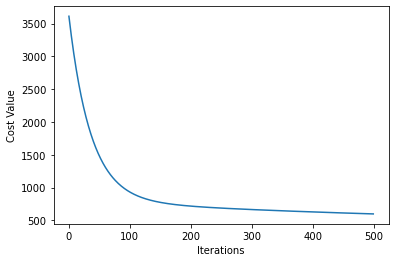

Train Result:

SSE for this regression model is:  1198.8582927895377
MSE for this regression model is:  34.624533105726314


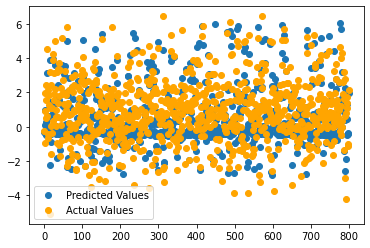

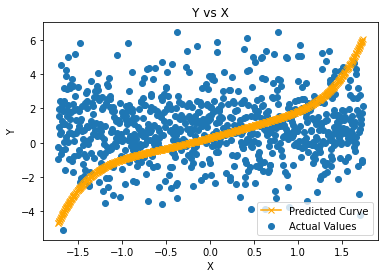

Test Result:

SSE for this regression model is:  350.24523904296495
MSE for this regression model is:  18.71484007527088


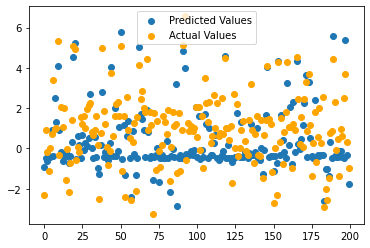

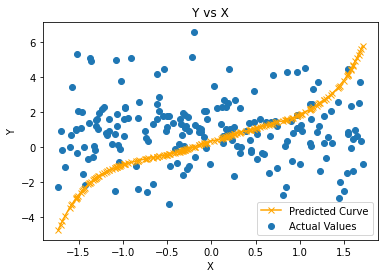

In [46]:
# for alpha = 0.0001
learning_rate = 0.0000015
degree = 5
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

Cost Function:



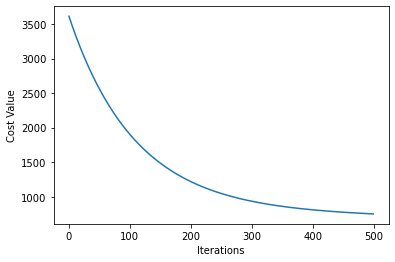

Train Result:

SSE for this regression model is:  1502.810508349695
MSE for this regression model is:  38.7660999889039


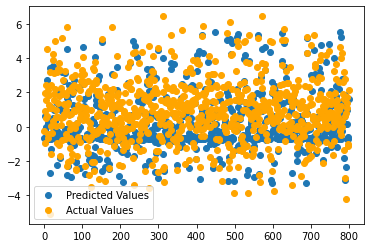

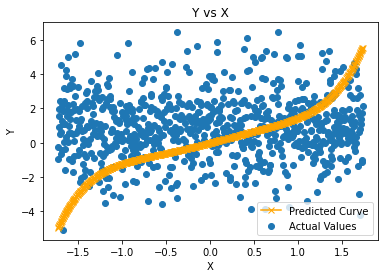

Test Result:

SSE for this regression model is:  438.82146512655453
MSE for this regression model is:  20.948065904196373


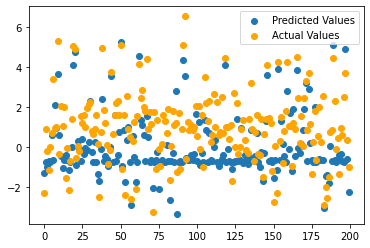

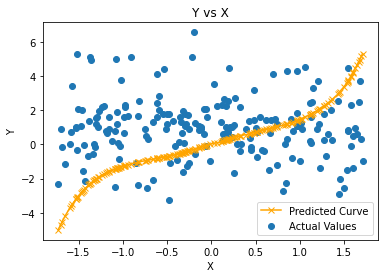

In [47]:
# for alpha = 0.0000005
learning_rate = 0.0000005
degree = 5
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

## ```Test Run for Polynomial with degree 6```

Cost Function:



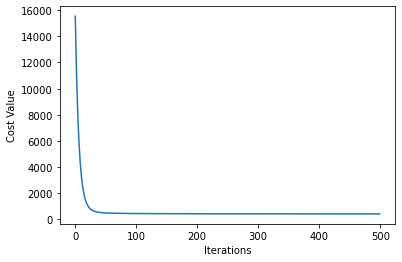

Train Result:

SSE for this regression model is:  794.0805388070969
MSE for this regression model is:  28.179434678628613


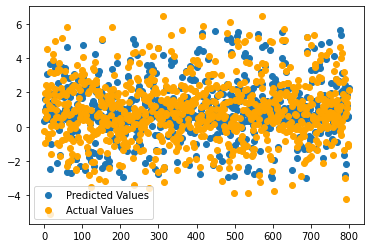

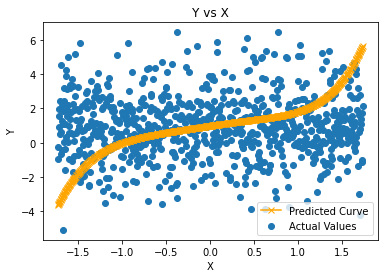

Test Result:

SSE for this regression model is:  203.17766825139992
MSE for this regression model is:  14.254040418470824


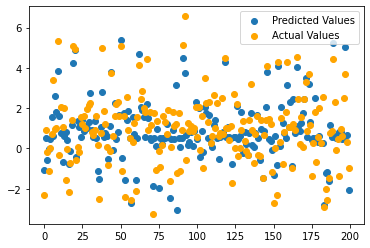

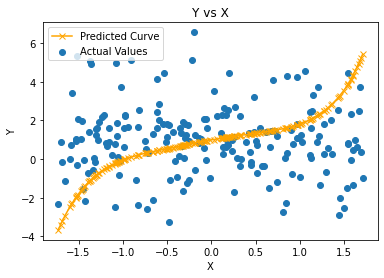

In [48]:
# for alpha = 0.0001
learning_rate = 0.000035
degree = 6
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

Cost Function:



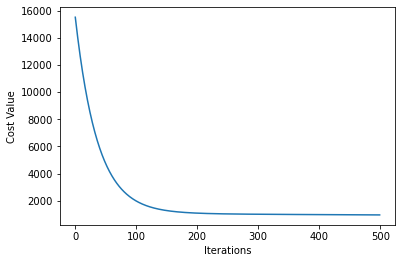

Train Result:

SSE for this regression model is:  1897.1575385247208
MSE for this regression model is:  43.55637196237447


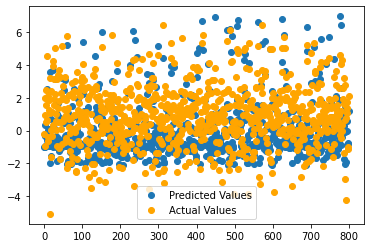

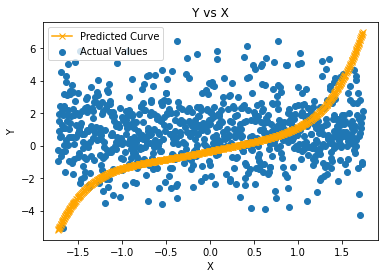

Test Result:

SSE for this regression model is:  532.9964110797782
MSE for this regression model is:  23.086715034404055


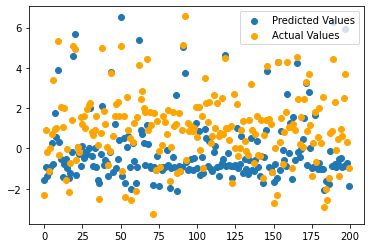

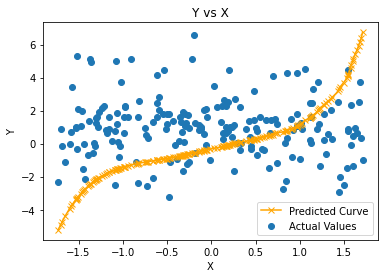

In [49]:
# for alpha = 0.0001
learning_rate = 0.00000025
degree = 6
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

Cost Function:



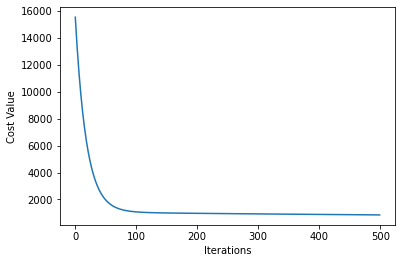

Train Result:

SSE for this regression model is:  1706.2245376374701
MSE for this regression model is:  41.306470893038906


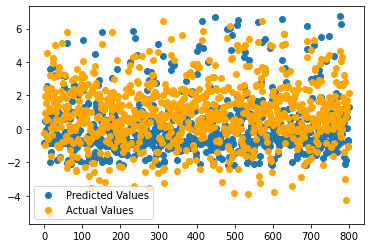

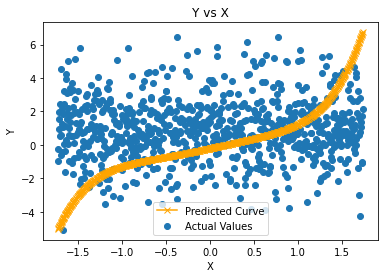

Test Result:

SSE for this regression model is:  482.3464966549211
MSE for this regression model is:  21.9623882274884


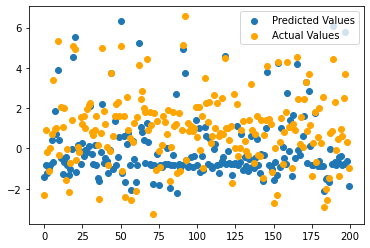

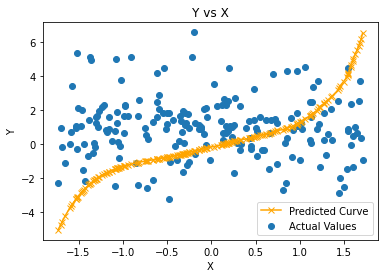

In [50]:
# for alpha = 0.0000005
learning_rate = 0.0000005
degree = 6
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

## ```Test Run for Polynomial with degree 7```

Cost Function:



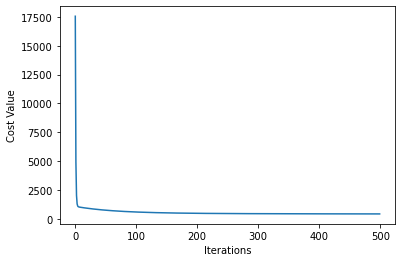

Train Result:

SSE for this regression model is:  823.1272181998769
MSE for this regression model is:  28.690193763721375


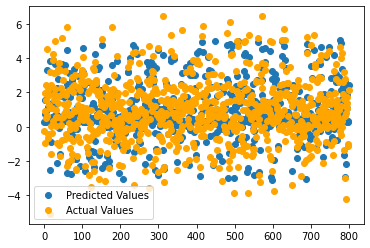

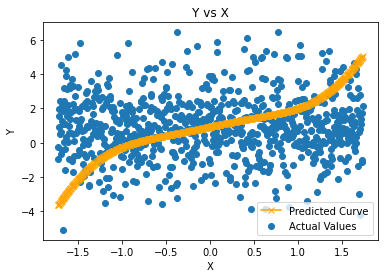

Test Result:

SSE for this regression model is:  222.9354645302532
MSE for this regression model is:  14.931023559363009


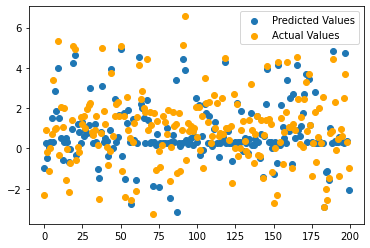

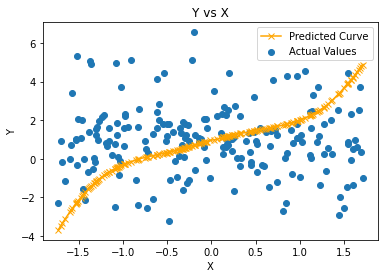

In [51]:
# for alpha = 0.0001
learning_rate = 0.000009
degree = 7
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

Cost Function:



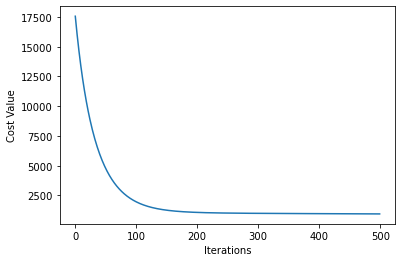

Train Result:

SSE for this regression model is:  1890.3691720001063
MSE for this regression model is:  43.47837591263163


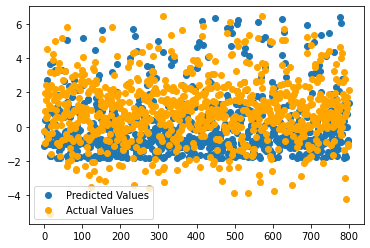

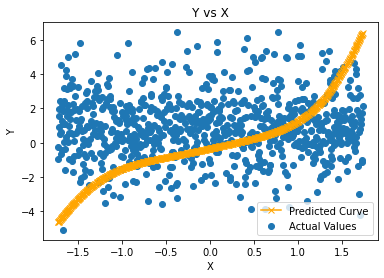

Test Result:

SSE for this regression model is:  534.0891877075989
MSE for this regression model is:  23.110369700798792


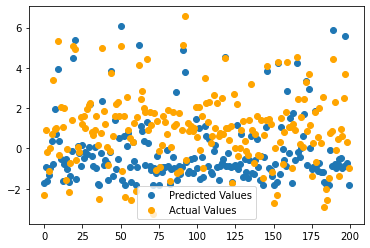

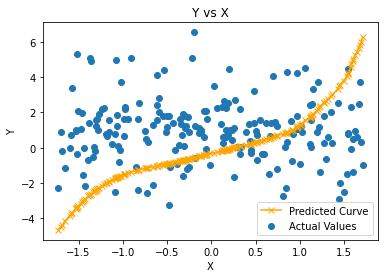

In [52]:
# for alpha = 0.0001
learning_rate = 0.00000025
degree = 7
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch =[]

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

Cost Function:



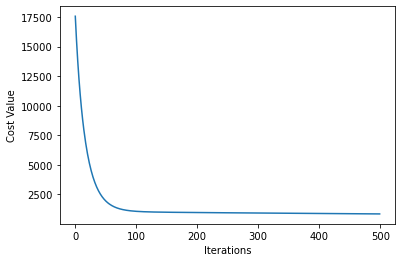

Train Result:

SSE for this regression model is:  1699.7451820376605
MSE for this regression model is:  41.227966018682764


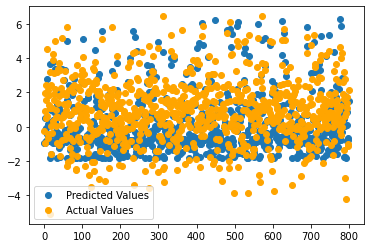

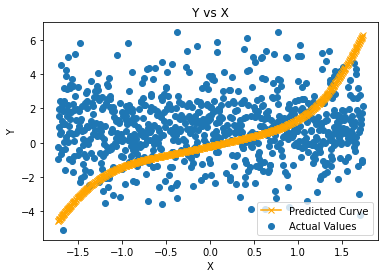

Test Result:

SSE for this regression model is:  482.9652752459526
MSE for this regression model is:  21.97647094612674


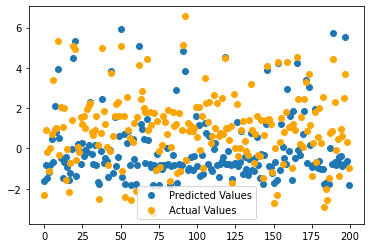

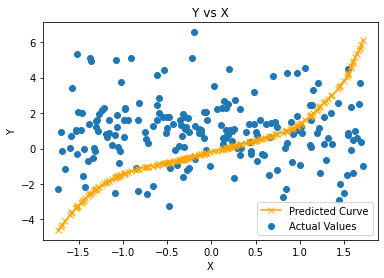

In [53]:
# for alpha = 0.0000005

learning_rate = 0.0000005
degree = 7
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

## ```Test Run for Polynomial with degree 8```

Cost Function:



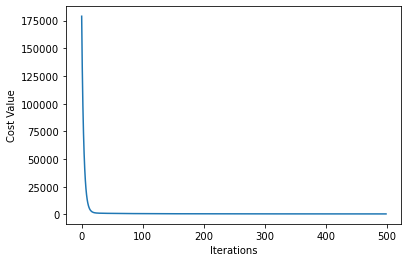

Train Result:

SSE for this regression model is:  882.8210098626482
MSE for this regression model is:  29.71230401471162


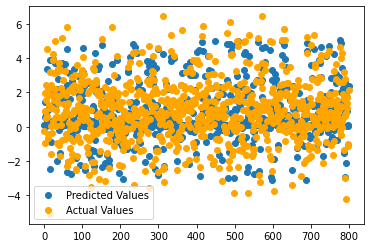

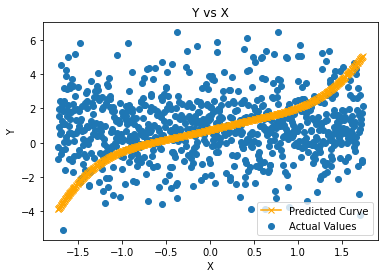

Test Result:

SSE for this regression model is:  248.59798432497334
MSE for this regression model is:  15.766990338202575


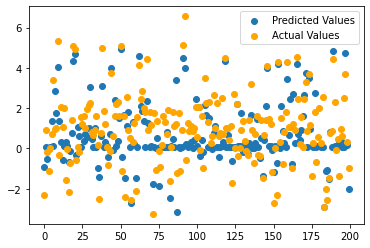

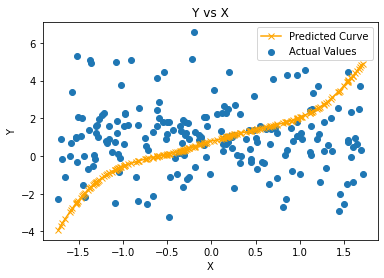

In [54]:
# for alpha = 0.0001
learning_rate = 0.000005
degree = 8
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

Cost Function:



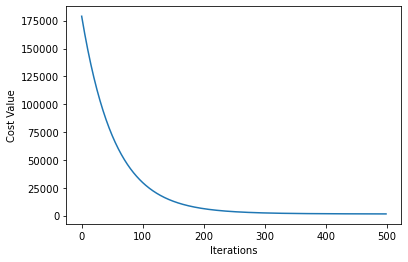

Train Result:

SSE for this regression model is:  2965.4090815595564
MSE for this regression model is:  54.45556979372777


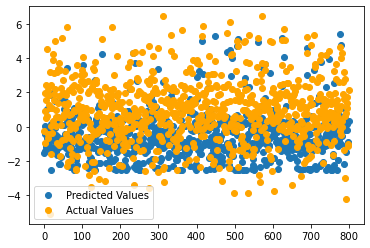

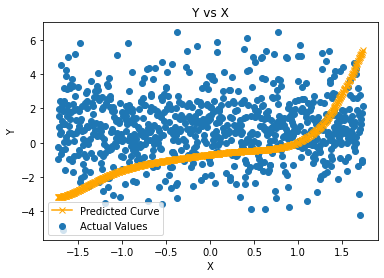

Test Result:

SSE for this regression model is:  788.3470108924947
MSE for this regression model is:  28.07751789052043


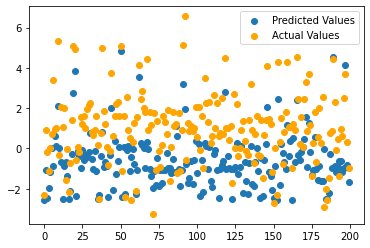

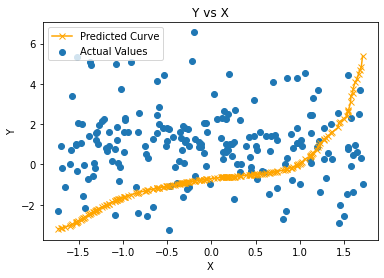

In [55]:
# for alpha = 0.0001
learning_rate = 0.000000025
degree = 8
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

Cost Function:



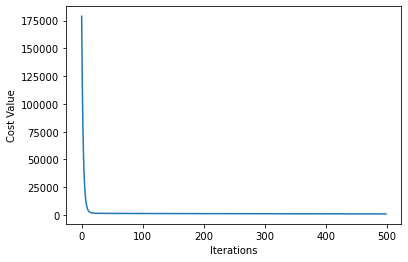

Train Result:

SSE for this regression model is:  1815.400521751109
MSE for this regression model is:  42.60751719768601


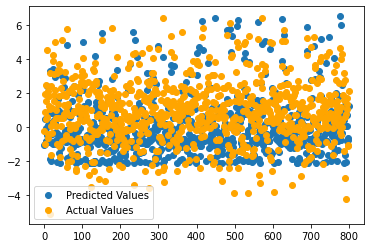

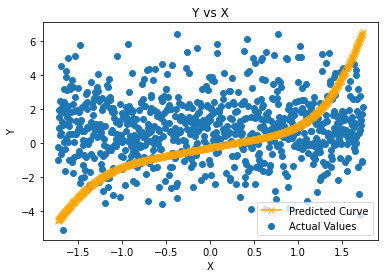

Test Result:

SSE for this regression model is:  509.3208255580115
MSE for this regression model is:  22.568137396737274


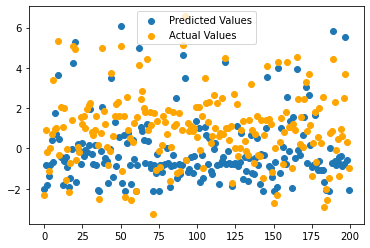

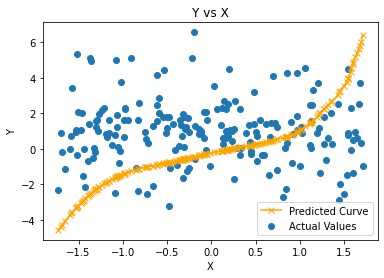

In [56]:
# for alpha = 0.0000005
learning_rate = 0.0000005
degree = 8
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

## ```Test Run for Polynomial with degree 9```

Cost Function:



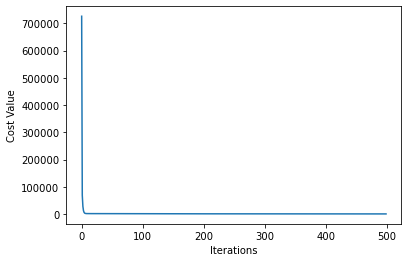

Train Result:

SSE for this regression model is:  1434.2275674187406
MSE for this regression model is:  37.87119706873207


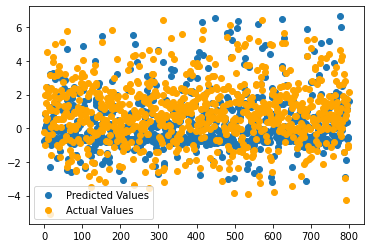

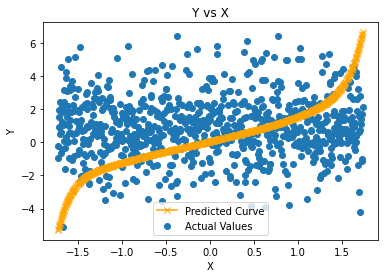

Test Result:

SSE for this regression model is:  414.7185246048798
MSE for this regression model is:  20.364639073769016


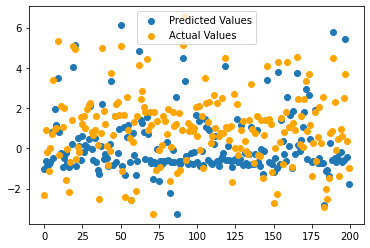

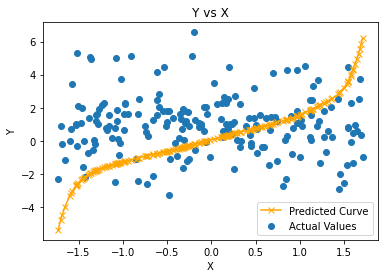

In [57]:
# for alpha = 0.0001
learning_rate = 0.000001
degree = 9
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

Cost Function:



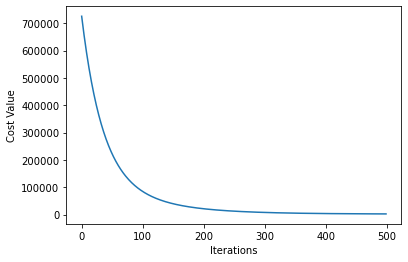

Train Result:

SSE for this regression model is:  4992.144600257198
MSE for this regression model is:  70.6551102204023


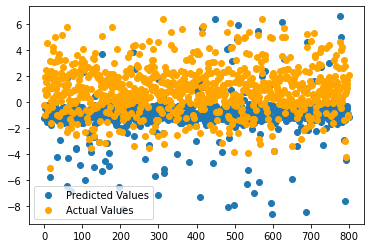

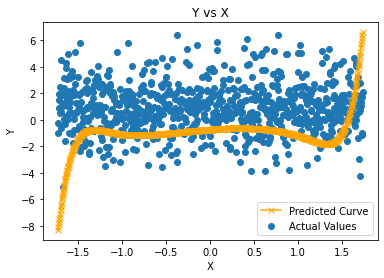

Test Result:

SSE for this regression model is:  1215.7980973713354
MSE for this regression model is:  34.86829645066325


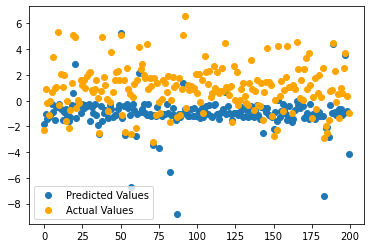

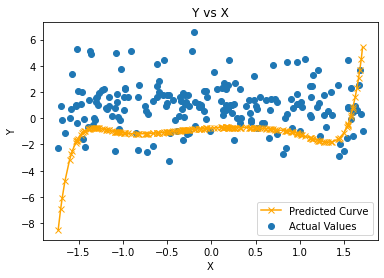

In [58]:
# for alpha = 0.0001
learning_rate = 0.000000015
degree = 9
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

Cost Function:



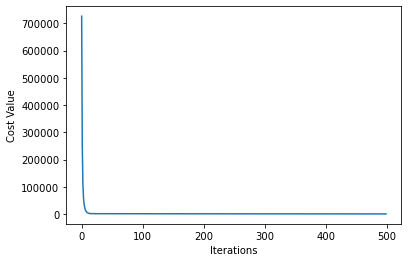

Train Result:

SSE for this regression model is:  2000.0095036292741
MSE for this regression model is:  44.72146580367502


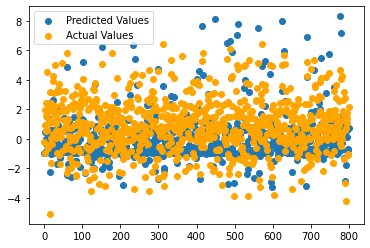

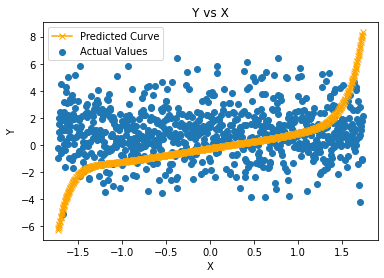

Test Result:

SSE for this regression model is:  544.5198549725553
MSE for this regression model is:  23.33494921726969


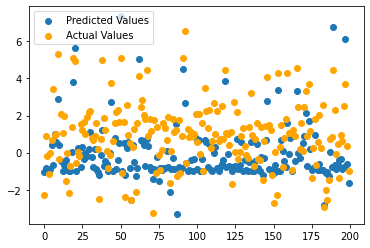

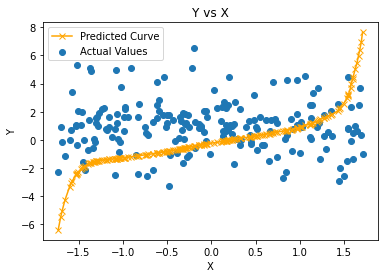

In [59]:
# for alpha = 0.0000005
learning_rate = 0.0000005
degree = 9
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
print_score(y_train,x_train,y_test,x_test,weight_vector,iteration_x_axis_batch,cost_y_axis_batch)

#  ```TASK 3: GRAPH PLOTTING```

##  ```(a) Training Errors v/s Degree of Polynomial graph```

### ```Constant learning rate = 0.0000005```

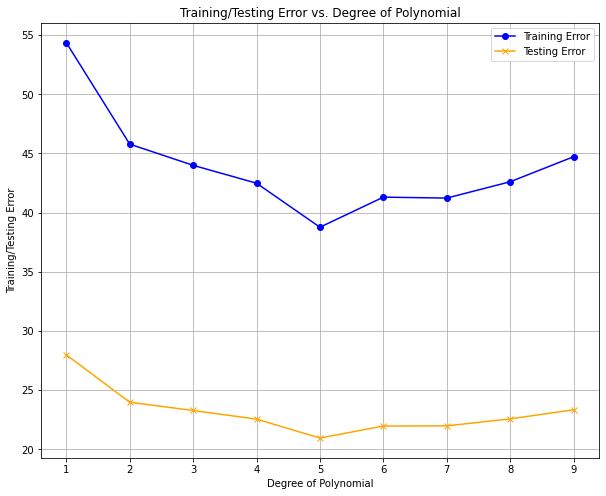

In [60]:
# Assuming you have the training error data in a list or array
learning_rate = 0.0000005

training_errors = []
degrees = np.arange(1, 10)  # Degrees 1 to 9
for i in degrees:
    iteration_x_axis_batch = []
    cost_y_axis_batch = []
    mse_y_batch = []
    x_train, y_train, x_test, y_test = give_train_data(dataset,"X",i)
    weight_vector = batch_gradient_descent(dataset,i,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
    y_predicted = find_predicted_value(weight_vector,x_train)
    training_error = find_mse(y_train, y_predicted)
    training_errors.append(training_error)
    
testing_errors = []
for i in degrees:
    iteration_x_axis_batch = []
    cost_y_axis_batch = []
    mse_y_batch = []
    x_train, y_train, x_test, y_test = give_train_data(dataset,"X",i)
    weight_vector = batch_gradient_descent(dataset,i,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
    y_test_predicted = find_predicted_value(weight_vector,x_test)
    testing_error = find_mse(y_test, y_test_predicted)
    testing_errors.append(testing_error)


# Plot the training error
plt.figure(figsize=(10, 8))
plt.plot(degrees, training_errors, marker = 'o', color = 'blue',label='Training Error')
plt.plot(degrees, testing_errors, marker = 'x', color = 'orange' , label= 'Testing Error')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Training/Testing Error')
plt.title('Training/Testing Error vs. Degree of Polynomial')
plt.legend()
plt.grid(True)
plt.show()

## ```(b) Training Error v/s Epochs for all degree of polynomials [1,9]```

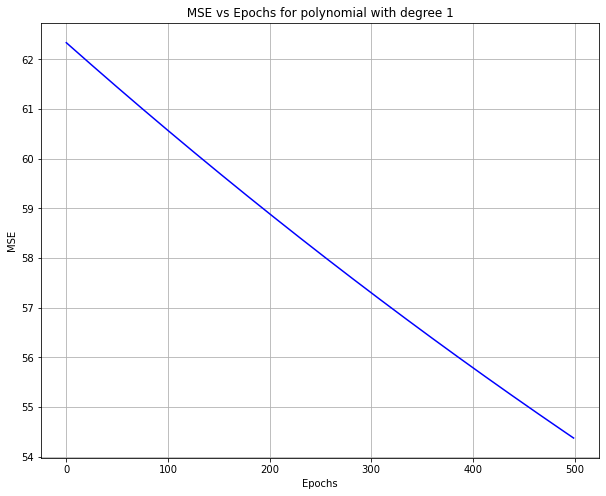

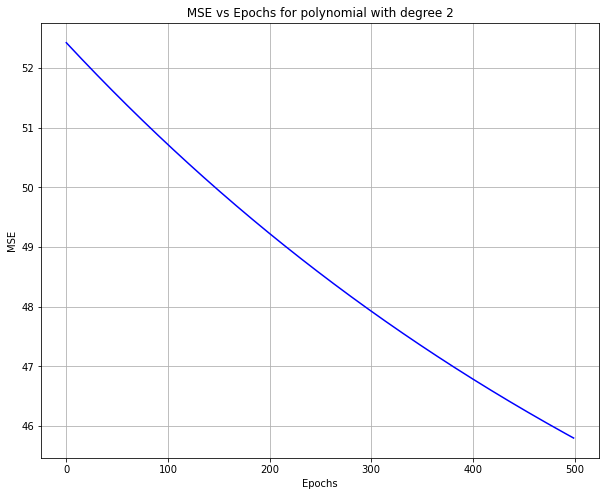

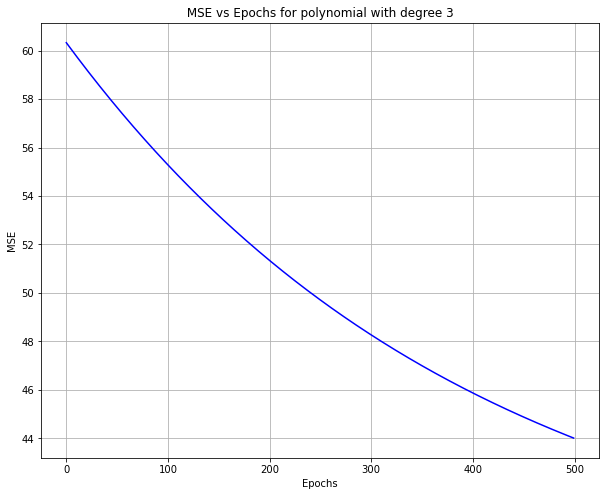

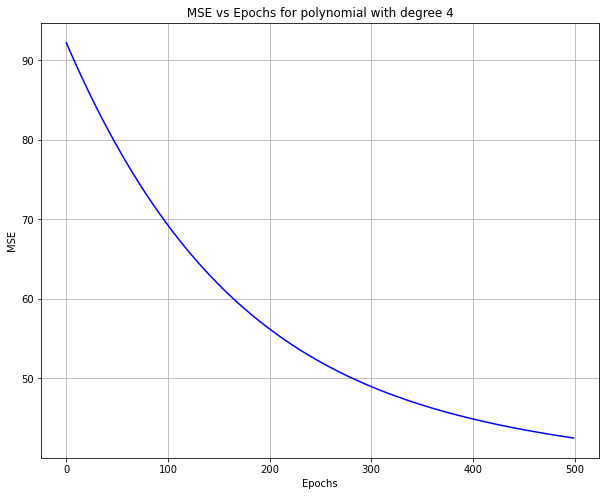

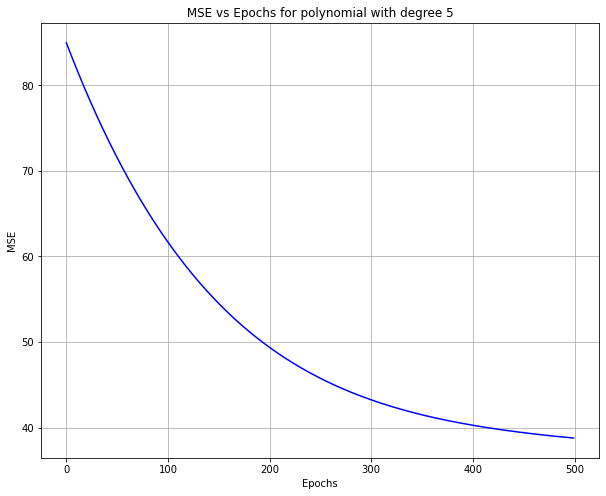

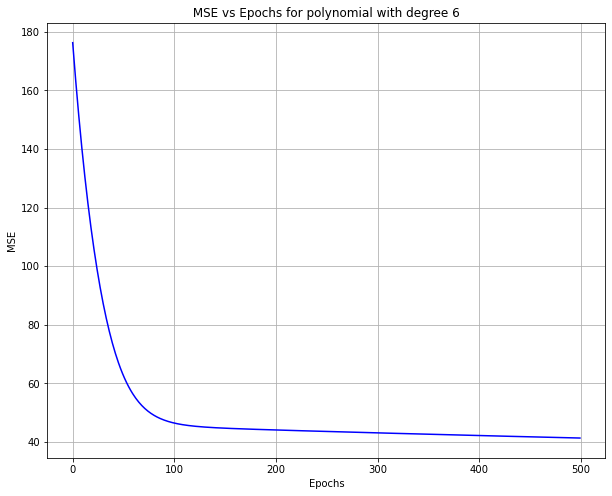

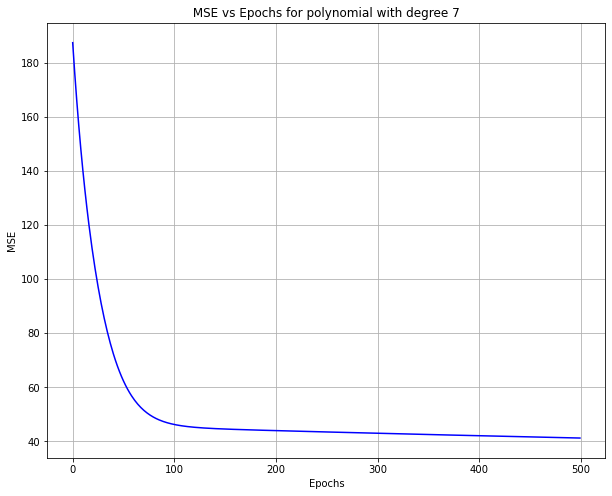

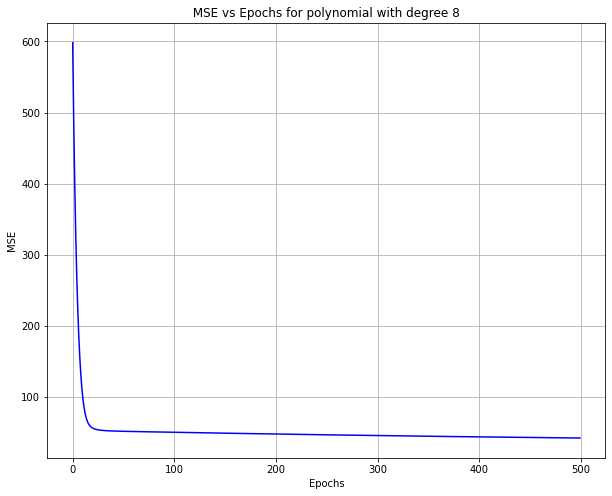

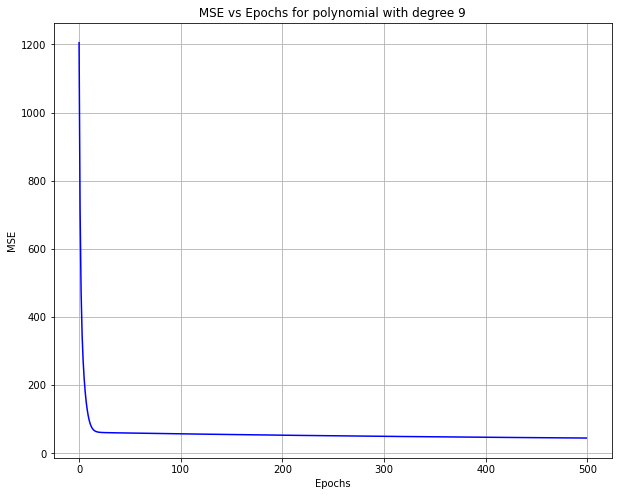

In [61]:
learning_rate = 0.0000005
degrees = np.arange(1, 10)  # Degrees 1 to 9
for i in degrees:
    iteration_x_axis_batch = []
    cost_y_axis_batch = []
    mse_y_batch = []
    x_train, y_train, x_test, y_test = give_train_data(dataset,"X",i)
    weight_vector = batch_gradient_descent(dataset,i,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
    plt.figure(figsize=(10, 8))
    plt.plot(iteration_x_axis_batch, mse_y_batch, color = 'blue')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.title(f" MSE vs Epochs for polynomial with degree {i} ")
    plt.grid(True)
    plt.show()

# ```(c) Best Fit Curve```

### ```By plotting the training/testing error vs degree curve , we see that our data best fits to a polynomial of degree 5```

In [62]:
def plot_poly_curve(x_train,y_actual,weight_vector):
    sorted_indices = np.argsort(x_train, axis=0)
    a = len(weight_vector)
    x_train_sorted = np.take_along_axis(x_train, sorted_indices, axis=0)
    y_predicted = find_predicted_value(weight_vector,x_train_sorted)
    df = pd.DataFrame(x_train_sorted, columns = ["fX{i}" for i in range(a)])
    X = df.iloc[:,1]
    plt.title("Y vs X")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.plot(X,y_predicted,color = 'orange',label = "Predicted Curve")
    plt.legend()
    plt.show()

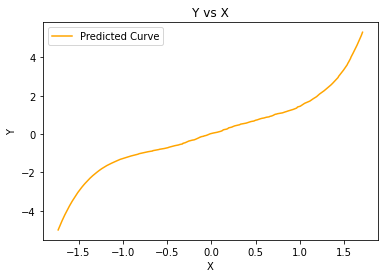

In [63]:
# for alpha = 0.0000005
learning_rate = 0.0000005
degree = 5
iteration_x_axis_batch = []
cost_y_axis_batch = []
mse_y_batch = []

weight_vector = batch_gradient_descent(dataset,degree,learning_rate,iteration_x_axis_batch,cost_y_axis_batch,mse_y_batch)
x_train, y_train, x_test, y_test = give_train_data(dataset,"X",degree)
plot_poly_curve(x_test.to_numpy(),y_test,weight_vector)

# ```TASK 4: COMPARATIVE ANALYSIS```


1. Comparative Analysis of the nine polynomials generated above gives us ```valuable insights``` so as to how the polynomials are performing after the given dataset is split into ```training data``` and ```testing data```.



2. We implemented ```Batch Gradient Descent```, where we train our model, i.e., initializing the model parameters, defining a cost function, computing sum of squares of errors and mean squared error, and updating the parameters as we try to minimize the cost function

3. We first defined functions for generating the ```polynomial functions```, computing ```SSE and MSE```, and other functions useful in analyzing the given dataset. We plotted graphs for polynomials of degree 1 to 9, respectively

4. Upon plotting the graphs, we can observe that for a ```constant learning rate``` (0.0000005 in this case), the Cost v/s Iterations curves become ```steeper```, i.e., the cost function decreases rapidly for lesser number of iterations as the degree of polynomial increases. 

5. For any degree of polynomial (degree 1 to 9), the cost v/s iteration curve ```diverges``` for very high learning rate.

6. We plotted three graphs for every degree of polynomial from 1 to 9, from which we observed that we get a better curve and a similar value of mean square error (MSE) for ```smaller values``` of learning rate, as the degree of the polynomial increases. 

7. From the plot of training/testing error v/s degree of the polynomial, we can observe that the testing error is relatively lesser than the training error. Thus, we can say that the model we developed is ```not potentially overfitting```.

8. We have also plotted graphs for MSE v/s epochs for every degree of polynomial from 1 to 9, from which we conclude ```MSE is decreasing``` as number of ```iterations increases```, since the weight vector updates after each iteration, as the error function reaches its global minima.

9. By plotting numerous graphs, we see that out data best fits in the polynomial of degree 5, and corresponding predicted curve has been plotted, with the x-axis denoting the independent variable x, and the y-axis denoting the dependent variable y.

10. From the above graphs, we can say that at ```learning rate = 0.0000005```, most of the polynomials are underfitting as the training error is fairly higher. However, at a different learning rate, these polynomials are a good fit for the given dataset, for instance, the polynomial of degree 5 is a good fit curve at learning rate = 0.00009. 

11. In this way, the graphs plotted can be analysed to determine ```overfitting or underfitting``` or best fit curves at some learning rates, using Batch Gradient Descent.

### ```END OF ASSIGNMENT 1A - REGRESSION WITHOUT REGULARIZATION``` 